# Define CNN Architecture

### Importing Libraries, model and data

In [0]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms,utils,models
import torch.nn as nn
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [11]:
from model import Net
net = Net()
print(net)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=25600, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=136, bias=True)
)


In [0]:
from data_load import FacialKeypointsDataset
from data_load import Rescale, RandomCrop, Normalize, ToTensor
data_transform = transforms.Compose([Rescale(250),RandomCrop(224),Normalize(),ToTensor()])
assert(data_transform is not None), 'Define a data_transform'

In [13]:
transformed_dataset = FacialKeypointsDataset('data/training_frames_keypoints.csv','data/training/',transform=data_transform)
print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


### Batch Data Loader

In [0]:
batch_size = 64
train_loader = DataLoader(transformed_dataset,batch_size = batch_size,shuffle = True,num_workers = 4)

## Before Training

### Load test dataset

In [0]:
test_dataset = FacialKeypointsDataset('data/test_frames_keypoints.csv','data/test/',transform = data_transform)
test_loader = DataLoader(test_dataset,batch_size = 64,shuffle=True,num_workers=0)

### Applying untrained model to test set

In [0]:
def net_sample_output():
    for i,sample in enumerate(test_loader):
        img,key_pts = sample['image'],sample['keypoints']
        img = img.type(torch.FloatTensor)
        net.cpu()
        output_pts = net(img)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        if i==0:
            return img,output_pts,key_pts

In [17]:
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


## Visualising test results

In [0]:
def show_all_keypoints(img,predicted_pts,gt_pts = None):
    plt.imshow(img,cmap = 'gray')
    plt.scatter(predicted_pts[:,0],predicted_pts[:,1],s = 30, c = 'm',marker = '.')
    if gt_pts is not None:
        plt.scatter(gt_pts[:,0],gt_pts[:,1],s = 30, c = 'g',marker = '.')

### Untransformation

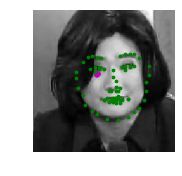

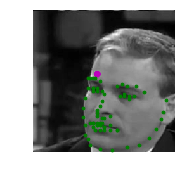

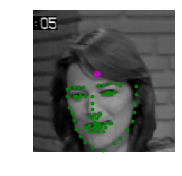

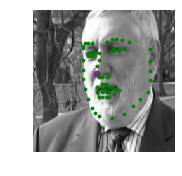

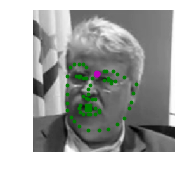

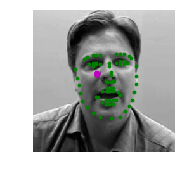

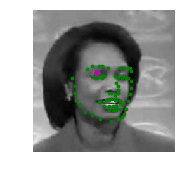

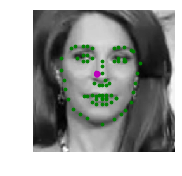

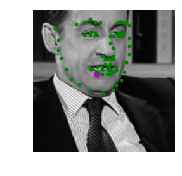

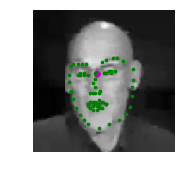

In [19]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(30,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

In [0]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(),lr=.0001)


In [0]:
def train_net(n_epochs):
    net.to(device)
    net.train()
    loss_array = []
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for batch_i,data in enumerate(train_loader):
            optimizer.zero_grad()
            img = data['image']
            key_pts = data['keypoints']
            key_pts = key_pts.view(key_pts.size(0),-1)
            
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            img = img.type(torch.cuda.FloatTensor)
            
            output_pts = net(img)
            loss = criterion(output_pts,key_pts)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            #if batch_i % 10 == 9:    
                #print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                #running_loss = 0.0
        loss_array.append(epoch_loss)
        print('Epoch: {} \t\t Avg. Loss: {}'.format(epoch + 1, epoch_loss/1000))
    print('Finished Training')
    return loss_array

In [22]:
n_epochs = 20

loss = train_net(n_epochs)

Epoch: 1 		 Avg. Loss: 0.013379613250494003
Epoch: 2 		 Avg. Loss: 0.010296073541045189
Epoch: 3 		 Avg. Loss: 0.010301726922392845
Epoch: 4 		 Avg. Loss: 0.00998169457912445
Epoch: 5 		 Avg. Loss: 0.008692677997052669
Epoch: 6 		 Avg. Loss: 0.007944464288651943
Epoch: 7 		 Avg. Loss: 0.006632333680987358
Epoch: 8 		 Avg. Loss: 0.0056042585298418995
Epoch: 9 		 Avg. Loss: 0.004916627902537584
Epoch: 10 		 Avg. Loss: 0.004112601857632399
Epoch: 11 		 Avg. Loss: 0.004132754685357213
Epoch: 12 		 Avg. Loss: 0.0034536349326372145
Epoch: 13 		 Avg. Loss: 0.003120172884315252
Epoch: 14 		 Avg. Loss: 0.0029285695273429157
Epoch: 15 		 Avg. Loss: 0.0025871959794312714
Epoch: 16 		 Avg. Loss: 0.002340028973296285
Epoch: 17 		 Avg. Loss: 0.0023901594094932078
Epoch: 18 		 Avg. Loss: 0.0024627424106001853
Epoch: 19 		 Avg. Loss: 0.0018867296874523162
Epoch: 20 		 Avg. Loss: 0.002388365726917982
Finished Training


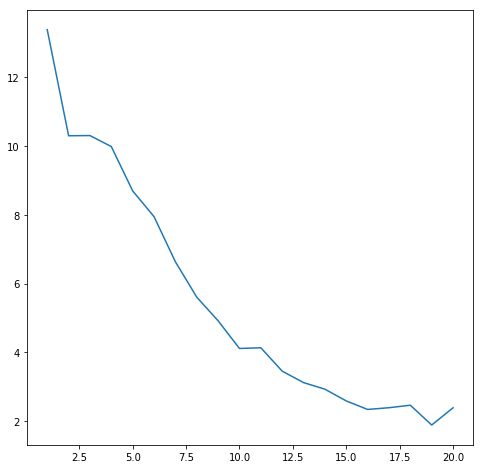

In [23]:
plt.figure(figsize = (8,8))
plt.plot(list(range(1,len(loss)+1)),loss)
plt.show()

In [0]:
model_dir = 'saved_models/'
model_name = 'keypoints_model.pt'
torch.save(net.state_dict(), model_dir+model_name)

In [34]:
net.load_state_dict(torch.load('saved_models/keypoints_model.pt'))

<All keys matched successfully>

## Test data

In [27]:
net.eval()

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=25600, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=136, bias=True)
)

In [32]:
test_img,test_output,gt_pts = net_sample_output()

print(test_img.data.size())
print(test_output.data.size())
print(gt_pts.data.size())

torch.Size([64, 1, 224, 224])
torch.Size([64, 68, 2])
torch.Size([64, 68, 2])


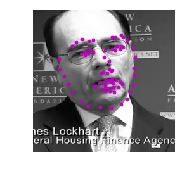

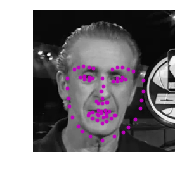

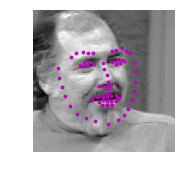

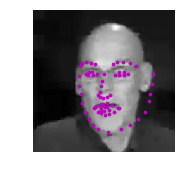

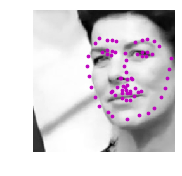

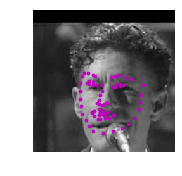

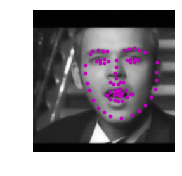

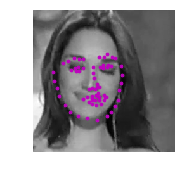

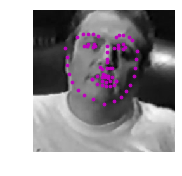

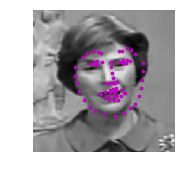

In [33]:
visualize_output(test_img, test_output)

## Feature Visualization

[[ 0.05151597 -0.15093285  0.00304972  0.16915308 -0.14515738]
 [ 0.02135127 -0.1536623   0.03819026  0.04673928 -0.06701163]
 [ 0.05745914  0.1835875  -0.03580025 -0.09929055 -0.06292453]
 [-0.08694445 -0.11500736 -0.13893634 -0.08674469  0.04920661]
 [-0.0398207  -0.18596908  0.07703196  0.13567188  0.11826149]]
(5, 5)


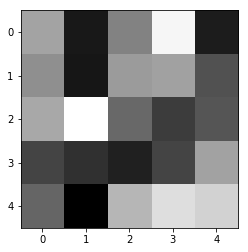

In [34]:
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')